### Initial Variable Definations

In [5]:
%pylab inline
%matplotlib
#%%writefile ../crypto_chaotic/audioClient.py
#!/usr/bin/env python

import pyaudio
import wave
from twisted.internet.protocol import DatagramProtocol
from twisted.internet import reactor
import numpy as np
from crypto_chaotic.modulation import drawfft
from matplotlib import rcParams
import matplotlib.pyplot as plt
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
#from scipy.fftpack import rfft, irfft, fftfreq

CHUNK = 44100*5
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
#RECORD_SECONDS = 60*60

tstep = 0.001 #0.0001
ndrop = 1500 #15000
N = 4

Amplification = 100000 #500000
Samples=2



def drawfft(signals, d=1, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), d=d)

        Nindex = np.argmax(freq < 0)
        #freq1 = np.append(freq[Nindex:], freq[:Nindex])
        #sp1 = np.append(sp[Nindex:], sp[:Nindex])
        freq1 = freq[:Nindex]/d
        sp1 = sp[:Nindex]
        print freq1
        plt.plot(freq1, sp1)
    plt.show()
    

Populating the interactive namespace from numpy and matplotlib
Using matplotlib backend: agg


### Voice Capture and preprocessing at Transmitter

In [6]:
p = pyaudio.PyAudio()

inputStream = p.open(format=FORMAT,
                     channels=CHANNELS,
                     rate=RATE,
                     input=True,
                     frames_per_buffer=CHUNK)

voicestream = inputStream.read(CHUNK)
inputStream.close()

#########################################
###     Voice Data                    ###
#########################################
modsig = np.fromstring(voicestream, dtype=np.int16)

#########################################
###         Frequency Domain          ###
#########################################
d=(1.0 * CHUNK)/RATE
#W = fftfreq(modsig.size, d=d)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
minm = (1.0*100*d)
maxm = (1.0*18000*d)

cut_f_signal = f_signal.copy()
for j in range(len(cut_f_signal)):
    if j < minm:
        cut_f_signal[j] = 0
    elif j > maxm:
        cut_f_signal[j] = 0

#########################################
###            Time Domain            ###
#########################################
tcut_signal0 = irfft(cut_f_signal)

In [9]:

cut_samples=np.zeros(len(tcut_signal0)*Samples, dtype=np.float64)
#for i in range(Samples):
#    cut_samples[i::Samples] = tcut_signal0
cut_samples[0::Samples] = tcut_signal0

'''#########################################
###         Frequency Domain          ###
#########################################
d=(1.0 * CHUNK)/RATE
#W = fftfreq(modsig.size, d=d)
f_signal = rfft(cut_samples)

#########################################
###              Filter               ###
#########################################
minm = (1.0*100*d)/(Samples/2)
maxm = (1.0*18000*d)/(Samples/2)

cut_f_signal = f_signal.copy()
for j in range(len(cut_f_signal)):
    if j < minm:
        cut_f_signal[j] = 0
    elif j > maxm:
        cut_f_signal[j] = 0

#########################################
###            Time Domain            ###
#########################################
tcut_signal1 = irfft(cut_f_signal)'''
tcut_signal1 = cut_samples

Populating the interactive namespace from numpy and matplotlib
(0, -1)


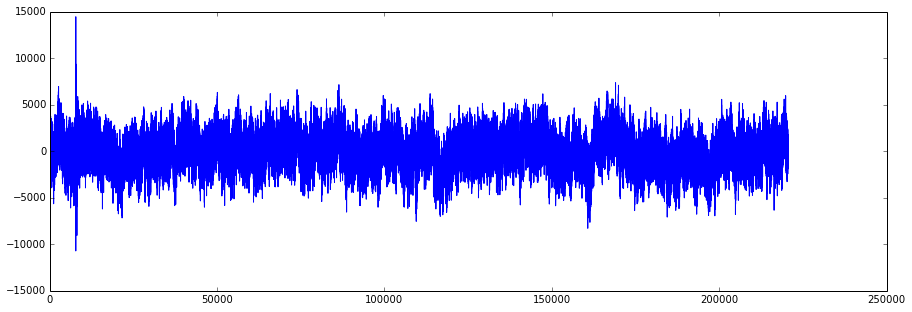

(0, 100)


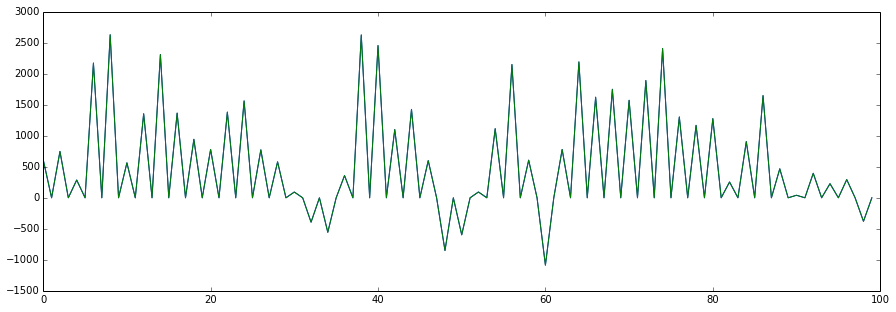

[  0.00000000e+00   1.81405896e-07   3.62811791e-07 ...,   1.99994558e-02
   1.99996372e-02   1.99998186e-02]


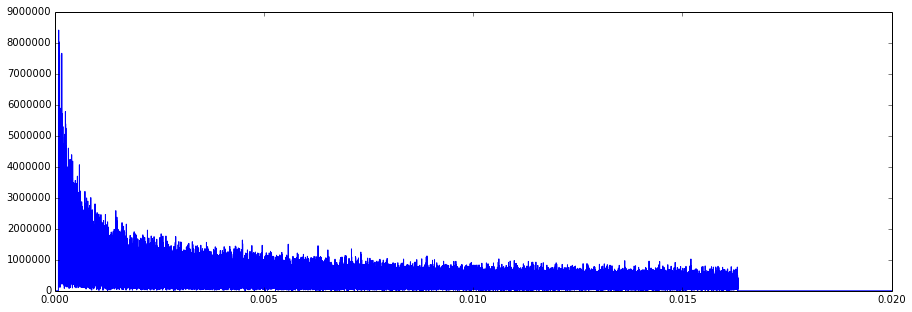

[  0.00000000e+00   9.07029478e-08   1.81405896e-07 ...,   1.99997279e-02
   1.99998186e-02   1.99999093e-02]


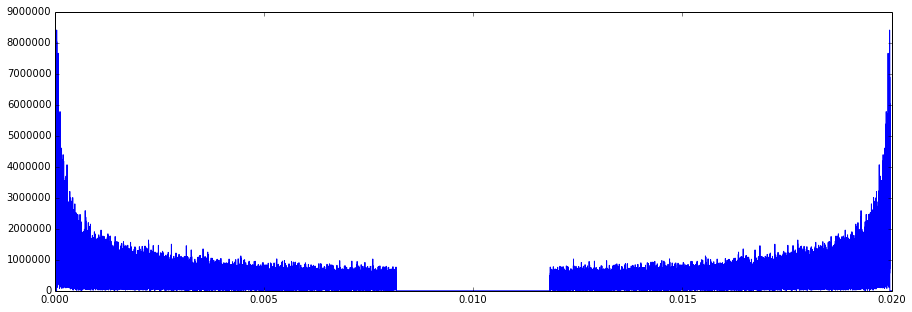

[  0.00000000e+00   9.07029478e-08   1.81405896e-07 ...,   1.99997279e-02
   1.99998186e-02   1.99999093e-02]


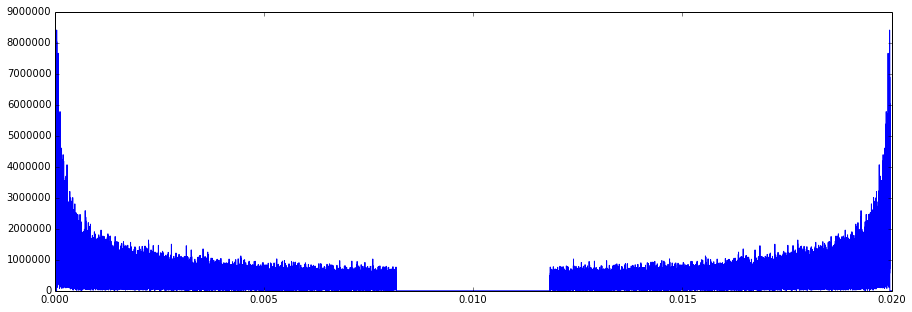

In [10]:
%pylab inline
modulation.plotamp([modsig], xmin = 0, xmax = 0)
modulation.plotamp([cut_samples, tcut_signal1], xmin = 0, xmax = 100)
drawfft([tcut_signal0],       d=d, xlow=0, xhigh=0, ylow=0, yhigh=0)
drawfft([cut_samples],  d=d, xlow=0, xhigh=0, ylow=0, yhigh=0)
drawfft([tcut_signal1], d=d, xlow=0, xhigh=0, ylow=0, yhigh=0)

### Chaos Encryption at Transmitter

Populating the interactive namespace from numpy and matplotlib
(0, -1)


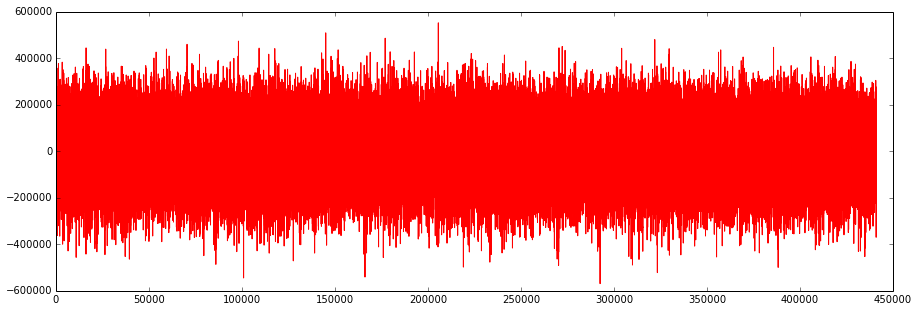

[  0.00000000e+00   4.53514739e-07   9.07029478e-07 ...,  -1.36054422e-06
  -9.07029478e-07  -4.53514739e-07]
[  0.00000000e+00   4.53514739e-07   9.07029478e-07 ...,  -1.36054422e-06
  -9.07029478e-07  -4.53514739e-07]
[  0.00000000e+00   4.53514739e-07   9.07029478e-07 ...,  -1.36054422e-06
  -9.07029478e-07  -4.53514739e-07]


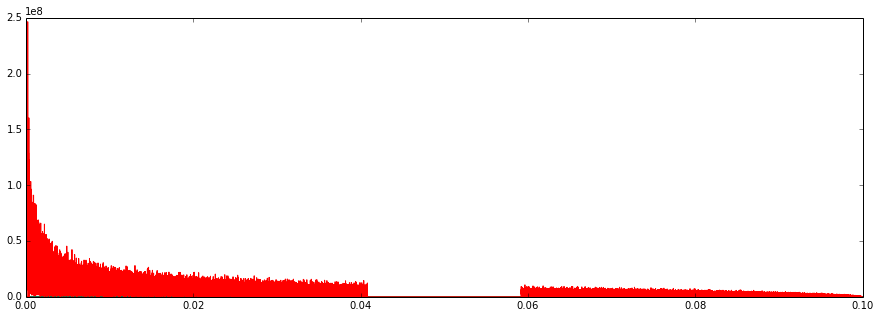

In [54]:
%pylab inline
#########################################
###     Time Domain Amplification     ###
#########################################
cut_signal = np.array(tcut_signal1/Amplification, dtype=np.float64)


#########################################
###           Chaos Encrypt           ###
#########################################
encryptedx, xt = lorenz_attractor.chaos_encrypt(cut_signal, 
                                                N = N, tstep = tstep, ndrop = ndrop)

modulation.plotamp([xt, encryptedx, cut_samples*100], xmin = 0, xmax = 0)
drawfft([xt, encryptedx, cut_samples*10], d=d, xlow=0, xhigh=0, ylow=0, yhigh=0)

### Chaos Decryption at Reciever

(0, -1)


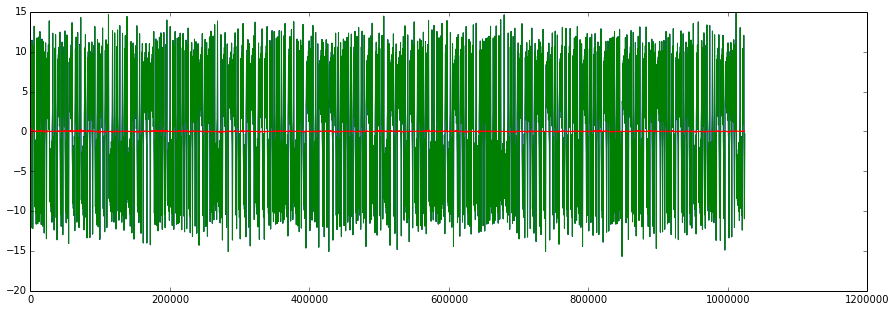

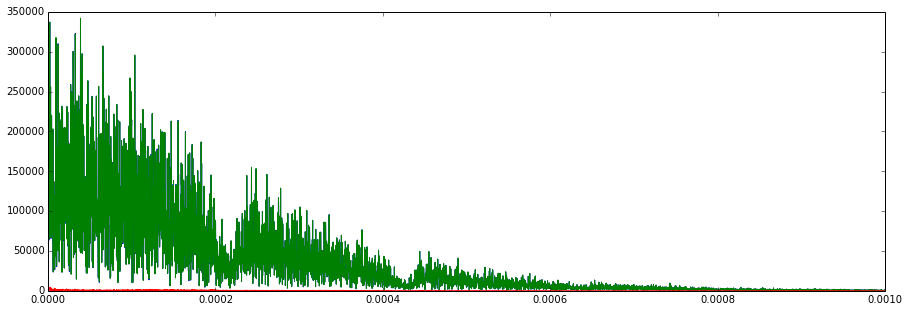

In [17]:
#########################################
###           Chaos Encrypt           ###
#########################################
recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx, 
                                               N = N, tstep = tstep, ndrop = ndrop)

#########################################
###     Time Domain Amplification     ###
#########################################
recovered_amp = recovered * Amplification

modulation.plotamp([encryptedx, xr, recovered], xmin = 0, xmax = 0)
drawfft([encryptedx, xr, recovered], d, xlow=0, xhigh=0.001, ylow=0, yhigh=0)


(20000, 40000)


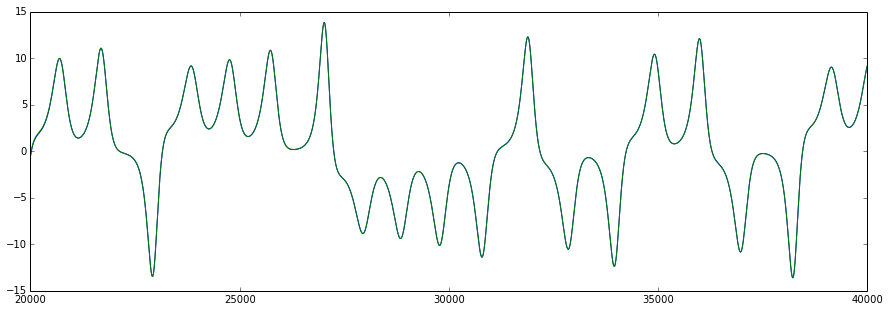

(20000, 40000)


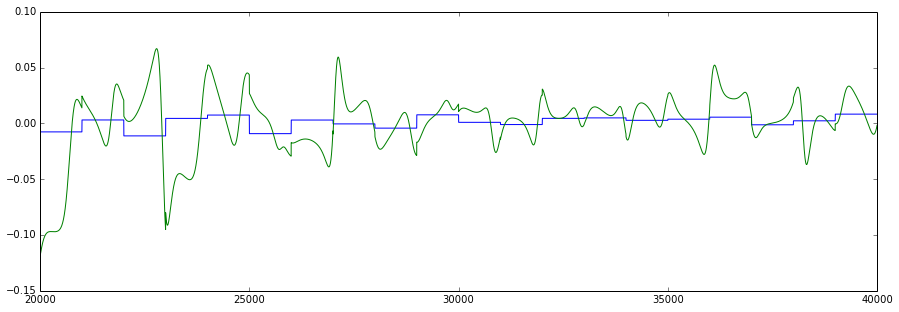

In [18]:
modulation.plotamp([xt, xr], xmin = 20000, xmax = 40000)
modulation.plotamp([cut_samples, recovered], xmin = 20000, xmax = 40000)

### Post Processing and Regeneration of Voice at Reciever

In [6]:
#########################################
###            Time Domain            ###
#########################################
recovered_buff = np.array(recovered_amp.astype(int), dtype=np.int16)

#########################################
###         Frequency Domain          ###
#########################################
d=(1.0 * CHUNK)/RATE
f_signal = rfft(recovered_buff[5000:])

#########################################
###              Filter               ###
#########################################
minm = 10*d
maxm = 10000*d
cut_f_signal = f_signal.copy()
for j in range(len(cut_f_signal)):
    if j < minm:
        cut_f_signal[j] = 0
    elif j > maxm:
        cut_f_signal[j] = 0

#########################################
###             Time Domain           ###
#########################################
rcut_signal0 = irfft(cut_f_signal)
cut_signal = np.array(rcut_signal0.astype(int), dtype=np.int16)

outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)

outputStream.write(cut_signal.tostring())
outputStream.close()

In [7]:
outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)
outputStream.write(voicestream)
outputStream.close()

In [20]:
a=np.zeros(10) 
print a
b=np.random.randint(0,100,5) # your 491 row matrix
print b
a[::2] = b
print a

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[80 66 60 61 36]
[ 80.   0.  66.   0.  60.   0.  61.   0.  36.   0.]


In [33]:
import numpy as np
a = np.empty(15)
a[3::2] = 1
print a

[ 0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.]
